### Summary

The idea here is to apply xgboost techniques on those predictors that are selected by lasso method. This way, we combine dimensionality reduction as well as non parametric techniques.

In [2]:
import pandas as pd
import numpy as np
import time as time
import xgboost as xgb

In [3]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Imputer
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler


In [4]:
INPUT_DIR = '../input/'

In [5]:
ts = time.time()
train = pd.read_csv(INPUT_DIR + 'train.csv')
time.time() - ts

5.227479934692383

In [51]:
ts = time.time()
test = pd.read_csv(INPUT_DIR + 'test.csv')
time.time() - ts

72.55899596214294

# Lasso section
In this section we construct a lasso model.

In [52]:
def evaluate_model_score(my_model, X, Y):
    predictions = my_model.predict(X)
    return evaluate_model_score_given_predictions(predictions, Y)

def make_predictions(my_model, X):
    predictions = my_model.predict(X)
    return predictions

def evaluate_model_score_given_predictions(predictions, Y):
    mean_of_squared_error1 = \
        mean_squared_error((np.log(np.abs(Y + 1))), (np.log(np.abs(predictions + 1))))
    return np.sqrt(mean_of_squared_error1)

def evaluate_neg_model_score(my_model, X, Y):
    return (-1) * evaluate_model_score(my_model, X, Y)


def cross_val_scores_given_model(my_model, X, Y, cv=5):
    cross_val_score1 = cross_val_score(my_model, 
                                       X, Y, 
                                       scoring=evaluate_model_score,
                                       cv=cv)
    return cross_val_score1

def cross_val_score_given_model(my_model, X, Y, cv=5):
    cross_val_score1 = cross_val_score(my_model, 
                                       X, Y,
                                       scoring=evaluate_model_score, 
                                       cv=cv)
                                       
    return cross_val_score1.mean()

def fit_pipeline_and_cross_validate(my_pipeline,
                                    train_data,
                                    X_columns,
                                    Y_column='target'):
    X = train_data[X_columns]
    Y = train_data[[Y_column]].values.ravel()
    my_pipeline.fit(X, Y)
    return (my_pipeline, cross_val_score_given_model(my_pipeline, X, Y))

#### A pipeline for impelmenting lasso model with normalization.

In [53]:
def get_lasso_pipe_with_scaling(alpha=2000):
    my_pipe = make_pipeline(StandardScaler(),linear_model.Lasso(alpha=alpha))
    return my_pipe

In [54]:
X_COLUMNS = [col for col in train.columns if col not in ['ID', 'target']]
Y_COLUMN = 'target'

In [55]:
# We are already aware of the data conversion to float and hence we suppress warnings regarding the same.
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [56]:
ALPHAS = np.concatenate([np.arange(100000, 1500000, 100000), np.arange(50000, 100000, 10000)])

In [57]:
alpha_to_cross_val_score = dict()

In [58]:
alpha_to_corr_pipe = dict()

In [59]:
ts = time.time()
for alpha_val in ALPHAS:
    (my_pipe, cross_val_score1) = fit_pipeline_and_cross_validate(
        get_lasso_pipe_with_scaling(alpha=alpha_val), 
        train, 
        X_COLUMNS)
    alpha_to_cross_val_score[alpha_val] = cross_val_score1
    alpha_to_corr_pipe[alpha_val] = my_pipe
time.time() -ts

333.9180557727814

In [60]:
alpha_to_cross_val_score

{100000: 1.961802716055687,
 200000: 1.9544845895654,
 300000: 1.96405332141402,
 400000: 1.9758551317784125,
 500000: 1.9850499883352342,
 600000: 1.9918723217614354,
 700000: 1.9977906171437056,
 800000: 2.0032383786330477,
 900000: 2.0083959792986263,
 1000000: 2.013499222571732,
 1100000: 2.0185609929491095,
 1200000: 2.023471759265643,
 1300000: 2.028317006226269,
 1400000: 2.03311781069742,
 50000: 2.049342716648238,
 60000: 2.0198157269999264,
 70000: 2.0022839876370555,
 80000: 1.9774939004861722,
 90000: 1.969811424242841}

In [61]:
optim_alpha = min(alpha_to_cross_val_score, key=alpha_to_cross_val_score.get)

In [62]:
optim_alpha

200000

In [65]:
optim_lass_model = alpha_to_corr_pipe.get(optim_alpha)

In [66]:
optim_lass_model.named_steps['lasso'].coef_!=0


array([False, False, False, ..., False, False, False])

In [67]:
np.sum(optim_lass_model.named_steps['lasso'].coef_!=0)


262

In [86]:
np.nonzero(optim_lass_model.named_steps['lasso'].coef_)[0]

array([   8,   11,   53,   60,   61,   66,  106,  144,  154,  184,  208,
        273,  306,  307,  344,  395,  413,  424,  429,  435,  461,  467,
        478,  493,  530,  547,  551,  564,  602,  622,  655,  690,  693,
        714,  733,  799,  803,  818,  819,  823,  827,  859,  878,  920,
        925,  936,  960,  966, 1035, 1042, 1047, 1057, 1097, 1129, 1142,
       1158, 1174, 1185, 1190, 1244, 1250, 1261, 1275, 1309, 1345, 1354,
       1358, 1362, 1370, 1438, 1533, 1537, 1552, 1556, 1564, 1595, 1629,
       1651, 1652, 1653, 1689, 1699, 1729, 1742, 1756, 1766, 1769, 1781,
       1791, 1824, 1836, 1847, 1873, 1887, 1894, 1902, 1942, 1943, 1950,
       1956, 1957, 1982, 1985, 1986, 1990, 2020, 2023, 2039, 2043, 2044,
       2084, 2120, 2161, 2166, 2220, 2221, 2225, 2232, 2241, 2299, 2337,
       2340, 2364, 2373, 2380, 2394, 2408, 2424, 2431, 2477, 2500, 2558,
       2580, 2582, 2594, 2612, 2636, 2651, 2656, 2661, 2682, 2705, 2721,
       2736, 2747, 2755, 2761, 2763, 2773, 2797, 28

# Xgboost section
In this section we construct an xgboost model on the predictors obtained using lasso regression.

In [96]:
X_COLUMNS = [X_COLUMNS[col] for col in np.nonzero(optim_lass_model.named_steps['lasso'].coef_)[0]]
Y_COLUMN = 'target'

In [97]:
X = train[X_COLUMNS].values
Y = train[[Y_COLUMN]].values

In [98]:
np.shape(X)

(4459, 262)

In [99]:
xgb_complete_data = xgb.DMatrix(X, Y, feature_names=X_COLUMNS)

In [100]:
#xgb_params = {'eta':0.01, 'eval_metric':'rmsle'}
xgb_params = {'eta':0.01, 'disable_default_eval_metric': 1}

In [101]:
from typing import Tuple, Dict, List
def gradient(predt: np.ndarray, dtrain: xgb.DMatrix) -> np.ndarray:
    '''Compute the gradient squared log error.'''
    y = dtrain.get_label()
    return (np.log1p(predt) - np.log1p(y)) / (predt + 1)

def hessian(predt: np.ndarray, dtrain: xgb.DMatrix) -> np.ndarray:
    '''Compute the hessian for squared log error.'''
    y = dtrain.get_label()
    return ((-np.log1p(predt) + np.log1p(y) + 1) /
            np.power(predt + 1, 2))

def squared_log(predt: np.ndarray,
                dtrain: xgb.DMatrix) -> Tuple[np.ndarray, np.ndarray]:
    '''Squared Log Error objective. A simplified version for RMSLE used as
    objective function.
    '''
    predt[predt < -1] = -1 + 1e-6
    grad = gradient(predt, dtrain)
    hess = hessian(predt, dtrain)
    return grad, hess


def rmsle(predt: np.ndarray, dtrain: xgb.DMatrix) -> Tuple[str, float]:
    ''' Root mean squared log error metric.'''
    y = dtrain.get_label()
    predt[predt < -1] = -1 + 1e-6
    elements = np.power(np.log1p(y) - np.log1p(predt), 2)
    return 'PyRMSLE', float(np.sqrt(np.sum(elements) / len(y)))

In [102]:
ts = time.time()
model_xgboost = xgb.cv(params=xgb_params,
                       dtrain=xgb_complete_data,
                       num_boost_round=1000,
                       nfold=5,
                       early_stopping_rounds=5,
                       obj=squared_log,
                       feval=rmsle,
                       callbacks=[xgb.callback.print_evaluation(show_stdv=False)]) 
time.time() - ts

[0]	train-PyRMSLE:14.1839	test-PyRMSLE:14.1838
[1]	train-PyRMSLE:14.1747	test-PyRMSLE:14.1746
[2]	train-PyRMSLE:14.1655	test-PyRMSLE:14.1653
[3]	train-PyRMSLE:14.1563	test-PyRMSLE:14.1561
[4]	train-PyRMSLE:14.1471	test-PyRMSLE:14.1469
[5]	train-PyRMSLE:14.1378	test-PyRMSLE:14.1377
[6]	train-PyRMSLE:14.1286	test-PyRMSLE:14.1285
[7]	train-PyRMSLE:14.1194	test-PyRMSLE:14.1192
[8]	train-PyRMSLE:14.1102	test-PyRMSLE:14.11
[9]	train-PyRMSLE:14.101	test-PyRMSLE:14.1008
[10]	train-PyRMSLE:14.0917	test-PyRMSLE:14.0916
[11]	train-PyRMSLE:14.0825	test-PyRMSLE:14.0824
[12]	train-PyRMSLE:14.0733	test-PyRMSLE:14.0732
[13]	train-PyRMSLE:14.0641	test-PyRMSLE:14.0639
[14]	train-PyRMSLE:14.0549	test-PyRMSLE:14.0547
[15]	train-PyRMSLE:14.0457	test-PyRMSLE:14.0455
[16]	train-PyRMSLE:14.0364	test-PyRMSLE:14.0363
[17]	train-PyRMSLE:14.0272	test-PyRMSLE:14.0271
[18]	train-PyRMSLE:14.018	test-PyRMSLE:14.0179
[19]	train-PyRMSLE:14.0088	test-PyRMSLE:14.0087
[20]	train-PyRMSLE:13.9996	test-PyRMSLE:13.9995
[21]	t

[170]	train-PyRMSLE:12.6243	test-PyRMSLE:12.6242
[171]	train-PyRMSLE:12.6152	test-PyRMSLE:12.6151
[172]	train-PyRMSLE:12.6061	test-PyRMSLE:12.6059
[173]	train-PyRMSLE:12.597	test-PyRMSLE:12.5968
[174]	train-PyRMSLE:12.5879	test-PyRMSLE:12.5877
[175]	train-PyRMSLE:12.5788	test-PyRMSLE:12.5786
[176]	train-PyRMSLE:12.5696	test-PyRMSLE:12.5695
[177]	train-PyRMSLE:12.5605	test-PyRMSLE:12.5604
[178]	train-PyRMSLE:12.5514	test-PyRMSLE:12.5513
[179]	train-PyRMSLE:12.5423	test-PyRMSLE:12.5421
[180]	train-PyRMSLE:12.5332	test-PyRMSLE:12.533
[181]	train-PyRMSLE:12.5241	test-PyRMSLE:12.5239
[182]	train-PyRMSLE:12.515	test-PyRMSLE:12.5148
[183]	train-PyRMSLE:12.5059	test-PyRMSLE:12.5057
[184]	train-PyRMSLE:12.4968	test-PyRMSLE:12.4966
[185]	train-PyRMSLE:12.4877	test-PyRMSLE:12.4875
[186]	train-PyRMSLE:12.4786	test-PyRMSLE:12.4784
[187]	train-PyRMSLE:12.4694	test-PyRMSLE:12.4693
[188]	train-PyRMSLE:12.4603	test-PyRMSLE:12.4602
[189]	train-PyRMSLE:12.4512	test-PyRMSLE:12.4511
[190]	train-PyRMSLE:12.

[338]	train-PyRMSLE:11.1123	test-PyRMSLE:11.1121
[339]	train-PyRMSLE:11.1035	test-PyRMSLE:11.1034
[340]	train-PyRMSLE:11.0948	test-PyRMSLE:11.0946
[341]	train-PyRMSLE:11.086	test-PyRMSLE:11.0858
[342]	train-PyRMSLE:11.0772	test-PyRMSLE:11.0771
[343]	train-PyRMSLE:11.0685	test-PyRMSLE:11.0683
[344]	train-PyRMSLE:11.0597	test-PyRMSLE:11.0596
[345]	train-PyRMSLE:11.051	test-PyRMSLE:11.0508
[346]	train-PyRMSLE:11.0422	test-PyRMSLE:11.0421
[347]	train-PyRMSLE:11.0335	test-PyRMSLE:11.0333
[348]	train-PyRMSLE:11.0248	test-PyRMSLE:11.0246
[349]	train-PyRMSLE:11.0161	test-PyRMSLE:11.0159
[350]	train-PyRMSLE:11.0073	test-PyRMSLE:11.0072
[351]	train-PyRMSLE:10.9986	test-PyRMSLE:10.9985
[352]	train-PyRMSLE:10.9899	test-PyRMSLE:10.9897
[353]	train-PyRMSLE:10.9812	test-PyRMSLE:10.981
[354]	train-PyRMSLE:10.9725	test-PyRMSLE:10.9724
[355]	train-PyRMSLE:10.9638	test-PyRMSLE:10.9637
[356]	train-PyRMSLE:10.9552	test-PyRMSLE:10.955
[357]	train-PyRMSLE:10.9465	test-PyRMSLE:10.9463
[358]	train-PyRMSLE:10.9

[506]	train-PyRMSLE:9.7979	test-PyRMSLE:9.79771
[507]	train-PyRMSLE:9.79169	test-PyRMSLE:9.7915
[508]	train-PyRMSLE:9.7855	test-PyRMSLE:9.78531
[509]	train-PyRMSLE:9.77933	test-PyRMSLE:9.77915
[510]	train-PyRMSLE:9.7732	test-PyRMSLE:9.77301
[511]	train-PyRMSLE:9.76708	test-PyRMSLE:9.76689
[512]	train-PyRMSLE:9.76099	test-PyRMSLE:9.76081
[513]	train-PyRMSLE:9.75493	test-PyRMSLE:9.75474
[514]	train-PyRMSLE:9.74889	test-PyRMSLE:9.74871
[515]	train-PyRMSLE:9.74288	test-PyRMSLE:9.74269
[516]	train-PyRMSLE:9.73689	test-PyRMSLE:9.73671
[517]	train-PyRMSLE:9.73093	test-PyRMSLE:9.73075
[518]	train-PyRMSLE:9.725	test-PyRMSLE:9.72481
[519]	train-PyRMSLE:9.71909	test-PyRMSLE:9.7189
[520]	train-PyRMSLE:9.7132	test-PyRMSLE:9.71301
[521]	train-PyRMSLE:9.70734	test-PyRMSLE:9.70715
[522]	train-PyRMSLE:9.7015	test-PyRMSLE:9.70132
[523]	train-PyRMSLE:9.69569	test-PyRMSLE:9.69551
[524]	train-PyRMSLE:9.68991	test-PyRMSLE:9.68972
[525]	train-PyRMSLE:9.68415	test-PyRMSLE:9.68396
[526]	train-PyRMSLE:9.67842	t

[675]	train-PyRMSLE:9.06363	test-PyRMSLE:9.06343
[676]	train-PyRMSLE:9.06075	test-PyRMSLE:9.06056
[677]	train-PyRMSLE:9.05789	test-PyRMSLE:9.05769
[678]	train-PyRMSLE:9.05504	test-PyRMSLE:9.05484
[679]	train-PyRMSLE:9.05219	test-PyRMSLE:9.052
[680]	train-PyRMSLE:9.04937	test-PyRMSLE:9.04917
[681]	train-PyRMSLE:9.04655	test-PyRMSLE:9.04635
[682]	train-PyRMSLE:9.04374	test-PyRMSLE:9.04354
[683]	train-PyRMSLE:9.04095	test-PyRMSLE:9.04075
[684]	train-PyRMSLE:9.03816	test-PyRMSLE:9.03797
[685]	train-PyRMSLE:9.03539	test-PyRMSLE:9.0352
[686]	train-PyRMSLE:9.03263	test-PyRMSLE:9.03244
[687]	train-PyRMSLE:9.02988	test-PyRMSLE:9.02969
[688]	train-PyRMSLE:9.02715	test-PyRMSLE:9.02695
[689]	train-PyRMSLE:9.02442	test-PyRMSLE:9.02422
[690]	train-PyRMSLE:9.0217	test-PyRMSLE:9.02151
[691]	train-PyRMSLE:9.019	test-PyRMSLE:9.0188
[692]	train-PyRMSLE:9.01631	test-PyRMSLE:9.01611
[693]	train-PyRMSLE:9.01362	test-PyRMSLE:9.01343
[694]	train-PyRMSLE:9.01095	test-PyRMSLE:9.01076
[695]	train-PyRMSLE:9.00829

[843]	train-PyRMSLE:8.70378	test-PyRMSLE:8.70358
[844]	train-PyRMSLE:8.70218	test-PyRMSLE:8.70198
[845]	train-PyRMSLE:8.70058	test-PyRMSLE:8.70038
[846]	train-PyRMSLE:8.69898	test-PyRMSLE:8.69878
[847]	train-PyRMSLE:8.69739	test-PyRMSLE:8.69719
[848]	train-PyRMSLE:8.6958	test-PyRMSLE:8.6956
[849]	train-PyRMSLE:8.69422	test-PyRMSLE:8.69402
[850]	train-PyRMSLE:8.69265	test-PyRMSLE:8.69244
[851]	train-PyRMSLE:8.69107	test-PyRMSLE:8.69087
[852]	train-PyRMSLE:8.6895	test-PyRMSLE:8.6893
[853]	train-PyRMSLE:8.68794	test-PyRMSLE:8.68774
[854]	train-PyRMSLE:8.68638	test-PyRMSLE:8.68618
[855]	train-PyRMSLE:8.68482	test-PyRMSLE:8.68462
[856]	train-PyRMSLE:8.68327	test-PyRMSLE:8.68307
[857]	train-PyRMSLE:8.68173	test-PyRMSLE:8.68152
[858]	train-PyRMSLE:8.68018	test-PyRMSLE:8.67998
[859]	train-PyRMSLE:8.67864	test-PyRMSLE:8.67844
[860]	train-PyRMSLE:8.67711	test-PyRMSLE:8.67691
[861]	train-PyRMSLE:8.67558	test-PyRMSLE:8.67538
[862]	train-PyRMSLE:8.67405	test-PyRMSLE:8.67385
[863]	train-PyRMSLE:8.67

58.44019603729248

In [103]:
model_xgboost[model_xgboost['test-PyRMSLE-mean'] == model_xgboost['test-PyRMSLE-mean'].min()]['test-PyRMSLE-mean']

999    8.497095
Name: test-PyRMSLE-mean, dtype: float64

In [104]:
model_xgboost[model_xgboost['test-PyRMSLE-mean'] == model_xgboost['test-PyRMSLE-mean'].min()].index[0]

999

### Not any improvement

We do not look to be getting any improvement with this method. Let us plot the importance of every feature and see if we can get a better result by using only the best predictors.

In [113]:
model_xgboost2 = xgb.train(params=xgb_params,
                           dtrain=xgb_complete_data,
                           num_boost_round=model_xgboost[model_xgboost['test-PyRMSLE-mean'] == model_xgboost['test-PyRMSLE-mean'].min()].index[0])

In [118]:
from xgboost import plot_importance
def plot_feature_importances(model_obj):
    fig, ax = plt.subplots(1, 1, figsize=(16, 9))
    plot_importance(booster=model_obj, ax=ax)

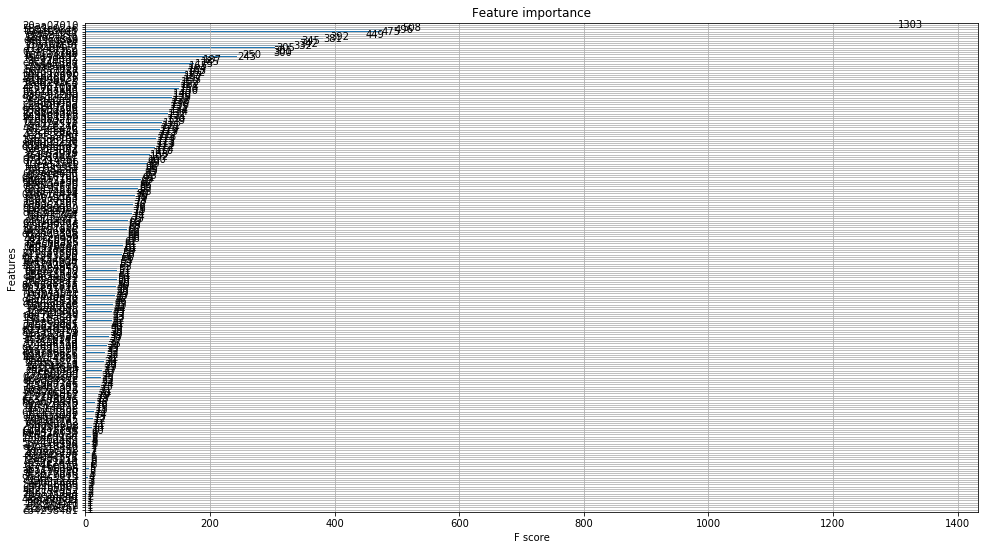

In [121]:
plot_feature_importances(model_xgboost2)

#### Since the plots is rather unintelligible, let us look at the individual values and pick the best predictors.

In [124]:
d = model_xgboost2.get_fscore()
s = [(k, d[k]) for k in sorted(d, key=d.get, reverse=True)]

In [125]:
s

[('20aa07010', 1303),
 ('58e2e02e6', 508),
 ('f190486d6', 496),
 ('6eef030c1', 475),
 ('f74e8f13d', 449),
 ('58232a6fb', 392),
 ('eeb9cd3aa', 381),
 ('9fd594eec', 345),
 ('15ace8c9f', 342),
 ('1702b5bf0', 332),
 ('1184df5c2', 305),
 ('024c577b9', 301),
 ('1c71183bb', 300),
 ('1d9078f84', 250),
 ('feed9d437', 243),
 ('3e37bffde', 187),
 ('edc84139a', 185),
 ('7aaefdfd7', 175),
 ('c2dae3a5a', 165),
 ('5a1589f1a', 164),
 ('06f6a7287', 163),
 ('bb1113dbb', 162),
 ('aa164b93b', 157),
 ('2d6bd8275', 157),
 ('d1fd0b9c2', 155),
 ('2599a7eb7', 152),
 ('ba4ceabc5', 152),
 ('4c60b70b8', 151),
 ('61c1b7eb6', 150),
 ('5c220a143', 150),
 ('b30e932ba', 140),
 ('9a3a1d59b', 139),
 ('8618bc1fd', 139),
 ('5f6ea2fa9', 138),
 ('42b407f0d', 136),
 ('c1ad8b95a', 136),
 ('645b47cde', 135),
 ('2288333b4', 134),
 ('96b6bd42b', 134),
 ('8c94b6675', 132),
 ('b4da814b8', 131),
 ('f1e0ada11', 130),
 ('0c9462c08', 129),
 ('73687e512', 123),
 ('cfc1ce276', 121),
 ('4824c1e90', 120),
 ('c3c633f64', 119),
 ('cb22f8a26

#### Let us pick the most important feature as per this metric and see how it performs.

In [174]:
X_COLUMNS = ['20aa07010']

In [178]:
ts = time.time()
X = train[X_COLUMNS].values
Y = train[[Y_COLUMN]].values
xgb_complete_data = xgb.DMatrix(X, Y, feature_names=X_COLUMNS)
model_xgboost = xgb.cv(params=xgb_params,
                       dtrain=xgb_complete_data,
                       num_boost_round=1000,
                       nfold=5,
                       early_stopping_rounds=5,
                       obj=squared_log,
                       feval=rmsle,
                       callbacks=[xgb.callback.print_evaluation(show_stdv=False)]) 
time.time() - ts

[0]	train-PyRMSLE:14.1839	test-PyRMSLE:14.1838
[1]	train-PyRMSLE:14.1747	test-PyRMSLE:14.1746
[2]	train-PyRMSLE:14.1655	test-PyRMSLE:14.1653
[3]	train-PyRMSLE:14.1563	test-PyRMSLE:14.1561
[4]	train-PyRMSLE:14.1471	test-PyRMSLE:14.1469
[5]	train-PyRMSLE:14.1378	test-PyRMSLE:14.1377
[6]	train-PyRMSLE:14.1286	test-PyRMSLE:14.1285
[7]	train-PyRMSLE:14.1194	test-PyRMSLE:14.1192
[8]	train-PyRMSLE:14.1102	test-PyRMSLE:14.11
[9]	train-PyRMSLE:14.101	test-PyRMSLE:14.1008
[10]	train-PyRMSLE:14.0917	test-PyRMSLE:14.0916
[11]	train-PyRMSLE:14.0825	test-PyRMSLE:14.0824
[12]	train-PyRMSLE:14.0733	test-PyRMSLE:14.0732
[13]	train-PyRMSLE:14.0641	test-PyRMSLE:14.0639
[14]	train-PyRMSLE:14.0549	test-PyRMSLE:14.0547
[15]	train-PyRMSLE:14.0457	test-PyRMSLE:14.0455
[16]	train-PyRMSLE:14.0364	test-PyRMSLE:14.0363
[17]	train-PyRMSLE:14.0272	test-PyRMSLE:14.0271
[18]	train-PyRMSLE:14.018	test-PyRMSLE:14.0179
[19]	train-PyRMSLE:14.0088	test-PyRMSLE:14.0087
[20]	train-PyRMSLE:13.9996	test-PyRMSLE:13.9995
[21]	t

[170]	train-PyRMSLE:12.6243	test-PyRMSLE:12.6242
[171]	train-PyRMSLE:12.6152	test-PyRMSLE:12.6151
[172]	train-PyRMSLE:12.6061	test-PyRMSLE:12.6059
[173]	train-PyRMSLE:12.597	test-PyRMSLE:12.5968
[174]	train-PyRMSLE:12.5879	test-PyRMSLE:12.5877
[175]	train-PyRMSLE:12.5788	test-PyRMSLE:12.5786
[176]	train-PyRMSLE:12.5696	test-PyRMSLE:12.5695
[177]	train-PyRMSLE:12.5605	test-PyRMSLE:12.5604
[178]	train-PyRMSLE:12.5514	test-PyRMSLE:12.5513
[179]	train-PyRMSLE:12.5423	test-PyRMSLE:12.5421
[180]	train-PyRMSLE:12.5332	test-PyRMSLE:12.533
[181]	train-PyRMSLE:12.5241	test-PyRMSLE:12.5239
[182]	train-PyRMSLE:12.515	test-PyRMSLE:12.5148
[183]	train-PyRMSLE:12.5059	test-PyRMSLE:12.5057
[184]	train-PyRMSLE:12.4968	test-PyRMSLE:12.4966
[185]	train-PyRMSLE:12.4877	test-PyRMSLE:12.4875
[186]	train-PyRMSLE:12.4786	test-PyRMSLE:12.4784
[187]	train-PyRMSLE:12.4694	test-PyRMSLE:12.4693
[188]	train-PyRMSLE:12.4603	test-PyRMSLE:12.4602
[189]	train-PyRMSLE:12.4512	test-PyRMSLE:12.4511
[190]	train-PyRMSLE:12.

[338]	train-PyRMSLE:11.1123	test-PyRMSLE:11.1121
[339]	train-PyRMSLE:11.1035	test-PyRMSLE:11.1034
[340]	train-PyRMSLE:11.0948	test-PyRMSLE:11.0946
[341]	train-PyRMSLE:11.086	test-PyRMSLE:11.0858
[342]	train-PyRMSLE:11.0772	test-PyRMSLE:11.0771
[343]	train-PyRMSLE:11.0685	test-PyRMSLE:11.0683
[344]	train-PyRMSLE:11.0597	test-PyRMSLE:11.0596
[345]	train-PyRMSLE:11.051	test-PyRMSLE:11.0508
[346]	train-PyRMSLE:11.0422	test-PyRMSLE:11.0421
[347]	train-PyRMSLE:11.0335	test-PyRMSLE:11.0333
[348]	train-PyRMSLE:11.0248	test-PyRMSLE:11.0246
[349]	train-PyRMSLE:11.0161	test-PyRMSLE:11.0159
[350]	train-PyRMSLE:11.0073	test-PyRMSLE:11.0072
[351]	train-PyRMSLE:10.9986	test-PyRMSLE:10.9985
[352]	train-PyRMSLE:10.9899	test-PyRMSLE:10.9897
[353]	train-PyRMSLE:10.9812	test-PyRMSLE:10.981
[354]	train-PyRMSLE:10.9725	test-PyRMSLE:10.9724
[355]	train-PyRMSLE:10.9638	test-PyRMSLE:10.9637
[356]	train-PyRMSLE:10.9552	test-PyRMSLE:10.955
[357]	train-PyRMSLE:10.9465	test-PyRMSLE:10.9463
[358]	train-PyRMSLE:10.9

[506]	train-PyRMSLE:9.7979	test-PyRMSLE:9.79771
[507]	train-PyRMSLE:9.79169	test-PyRMSLE:9.7915
[508]	train-PyRMSLE:9.7855	test-PyRMSLE:9.78531
[509]	train-PyRMSLE:9.77933	test-PyRMSLE:9.77915
[510]	train-PyRMSLE:9.7732	test-PyRMSLE:9.77301
[511]	train-PyRMSLE:9.76708	test-PyRMSLE:9.76689
[512]	train-PyRMSLE:9.76099	test-PyRMSLE:9.76081
[513]	train-PyRMSLE:9.75493	test-PyRMSLE:9.75474
[514]	train-PyRMSLE:9.74889	test-PyRMSLE:9.74871
[515]	train-PyRMSLE:9.74288	test-PyRMSLE:9.74269
[516]	train-PyRMSLE:9.73689	test-PyRMSLE:9.73671
[517]	train-PyRMSLE:9.73093	test-PyRMSLE:9.73075
[518]	train-PyRMSLE:9.725	test-PyRMSLE:9.72481
[519]	train-PyRMSLE:9.71909	test-PyRMSLE:9.7189
[520]	train-PyRMSLE:9.7132	test-PyRMSLE:9.71301
[521]	train-PyRMSLE:9.70734	test-PyRMSLE:9.70715
[522]	train-PyRMSLE:9.7015	test-PyRMSLE:9.70132
[523]	train-PyRMSLE:9.69569	test-PyRMSLE:9.69551
[524]	train-PyRMSLE:9.68991	test-PyRMSLE:9.68972
[525]	train-PyRMSLE:9.68415	test-PyRMSLE:9.68396
[526]	train-PyRMSLE:9.67842	t

[675]	train-PyRMSLE:9.06363	test-PyRMSLE:9.06343
[676]	train-PyRMSLE:9.06075	test-PyRMSLE:9.06056
[677]	train-PyRMSLE:9.05789	test-PyRMSLE:9.05769
[678]	train-PyRMSLE:9.05504	test-PyRMSLE:9.05484
[679]	train-PyRMSLE:9.05219	test-PyRMSLE:9.052
[680]	train-PyRMSLE:9.04937	test-PyRMSLE:9.04917
[681]	train-PyRMSLE:9.04655	test-PyRMSLE:9.04635
[682]	train-PyRMSLE:9.04374	test-PyRMSLE:9.04354
[683]	train-PyRMSLE:9.04095	test-PyRMSLE:9.04075
[684]	train-PyRMSLE:9.03816	test-PyRMSLE:9.03797
[685]	train-PyRMSLE:9.03539	test-PyRMSLE:9.0352
[686]	train-PyRMSLE:9.03263	test-PyRMSLE:9.03244
[687]	train-PyRMSLE:9.02988	test-PyRMSLE:9.02969
[688]	train-PyRMSLE:9.02715	test-PyRMSLE:9.02695
[689]	train-PyRMSLE:9.02442	test-PyRMSLE:9.02422
[690]	train-PyRMSLE:9.0217	test-PyRMSLE:9.02151
[691]	train-PyRMSLE:9.019	test-PyRMSLE:9.0188
[692]	train-PyRMSLE:9.01631	test-PyRMSLE:9.01611
[693]	train-PyRMSLE:9.01362	test-PyRMSLE:9.01343
[694]	train-PyRMSLE:9.01095	test-PyRMSLE:9.01076
[695]	train-PyRMSLE:9.00829

[843]	train-PyRMSLE:8.70378	test-PyRMSLE:8.70358
[844]	train-PyRMSLE:8.70218	test-PyRMSLE:8.70198
[845]	train-PyRMSLE:8.70058	test-PyRMSLE:8.70038
[846]	train-PyRMSLE:8.69898	test-PyRMSLE:8.69878
[847]	train-PyRMSLE:8.69739	test-PyRMSLE:8.69719
[848]	train-PyRMSLE:8.6958	test-PyRMSLE:8.6956
[849]	train-PyRMSLE:8.69422	test-PyRMSLE:8.69402
[850]	train-PyRMSLE:8.69265	test-PyRMSLE:8.69244
[851]	train-PyRMSLE:8.69107	test-PyRMSLE:8.69087
[852]	train-PyRMSLE:8.6895	test-PyRMSLE:8.6893
[853]	train-PyRMSLE:8.68794	test-PyRMSLE:8.68774
[854]	train-PyRMSLE:8.68638	test-PyRMSLE:8.68618
[855]	train-PyRMSLE:8.68482	test-PyRMSLE:8.68462
[856]	train-PyRMSLE:8.68327	test-PyRMSLE:8.68307
[857]	train-PyRMSLE:8.68173	test-PyRMSLE:8.68152
[858]	train-PyRMSLE:8.68018	test-PyRMSLE:8.67998
[859]	train-PyRMSLE:8.67864	test-PyRMSLE:8.67844
[860]	train-PyRMSLE:8.67711	test-PyRMSLE:8.67691
[861]	train-PyRMSLE:8.67558	test-PyRMSLE:8.67538
[862]	train-PyRMSLE:8.67405	test-PyRMSLE:8.67385
[863]	train-PyRMSLE:8.67

12.5188307762146

In [179]:
model_xgboost[model_xgboost['test-PyRMSLE-mean'] == model_xgboost['test-PyRMSLE-mean'].min()]['test-PyRMSLE-mean']

999    8.497095
Name: test-PyRMSLE-mean, dtype: float64

#### We do not look to be getting any improvement at all. Now, let us try the same with second most important metric.

In [7]:
X_COLUMNS = ['58e2e02e6']

In [ ]:
ts = time.time()
X = train[X_COLUMNS].values
Y = train[[Y_COLUMN]].values
xgb_complete_data = xgb.DMatrix(X, Y, feature_names=X_COLUMNS)
model_xgboost = xgb.cv(params=xgb_params,
                       dtrain=xgb_complete_data,
                       num_boost_round=1000,
                       nfold=5,
                       early_stopping_rounds=5,
                       obj=squared_log,
                       feval=rmsle,
                       callbacks=[xgb.callback.print_evaluation(show_stdv=False)]) 
time.time() - ts

In [ ]:
model_xgboost[model_xgboost['test-PyRMSLE-mean'] == model_xgboost['test-PyRMSLE-mean'].min()]['test-PyRMSLE-mean']

#### Absolutely the same result ! Just to confirm, let us try with random data.

In [ ]:
len_train = len(train)
X = np.reshape(np.random.rand(len_train), (len_train, 1))

In [ ]:
ts = time.time()
Y = train[[Y_COLUMN]].values
xgb_complete_data = xgb.DMatrix(X, Y, feature_names=X_COLUMNS)
model_xgboost = xgb.cv(params=xgb_params,
                       dtrain=xgb_complete_data,
                       num_boost_round=1000,
                       nfold=5,
                       early_stopping_rounds=5,
                       obj=squared_log,
                       feval=rmsle,
                       callbacks=[xgb.callback.print_evaluation(show_stdv=False)]) 
time.time() - ts

In [ ]:
model_xgboost[model_xgboost['test-PyRMSLE-mean'] == model_xgboost['test-PyRMSLE-mean'].min()]['test-PyRMSLE-mean']

#### This confirms our doubt. We do not look to be getting any benefit with this technique of combining lasso and xgboost methods. Let us move on from here !